In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [5]:
train_metadata = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_metadata = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_x = train_metadata.data[:50000].unsqueeze(1) / 255
val_x = train_metadata.data[-10000:].unsqueeze(1) / 255
test_x = test_metadata.data.unsqueeze(1) / 255
train_y = train_metadata.targets[:50000]
val_y = train_metadata.targets[-10000:]
test_y = test_metadata.targets

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'
BATCH_SIZE = 256
NUM_TRAIN = 50000
NUM_VAL = 10000
IMG_C = train_x.shape[-3]
IMG_H = train_x.shape[-2]
IMG_W = train_x.shape[-1]

train_data = TensorDataset(train_x, train_y)
val_data = TensorDataset(val_x, val_y)
test_data = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1000)

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
          nn.Conv2d(input_dim, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_var = nn.Linear(128 * 3 * 3, latent_dim)

    def forward(self, x):
        encoded = self.encode(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, output_dim, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.Flatten()
        )
        self.fc_probs = nn.Linear(31 * 31, IMG_H * IMG_W)

    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.decode(x)
        probs = torch.sigmoid(self.fc_probs(x))
        return probs

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z, mu_z, log_var_z = self.encoder(x)
        probs_x = self.decoder(z)
        return mu_z, log_var_z, probs_x

    def reconstruct(self, probs_x):
        bern_dist = torch.distributions.Bernoulli(probs_x)
        x_recon = bern_dist.sample()
        return x_recon.view(x_recon.shape[0], IMG_C, IMG_H, IMG_W)

In [8]:
LATENT_DIM = 16

encoder = Encoder(input_dim=IMG_C, latent_dim=LATENT_DIM)
decoder = Decoder(latent_dim=LATENT_DIM, output_dim=IMG_C)
vae = VAE(encoder, decoder).to(DEVICE)
print(vae)

VAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Linear(in_features=1152, out_features=16, bias=True)
    (fc_var): Linear(in_features=1152, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): ConvTranspose2d(16, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentu

  5%|▌         | 1/20 [00:07<02:22,  7.52s/it]

Epoch 1, Mean Training ELBO 198.5057347265625, Mean Validation ELBO 170.81834321289062


 10%|█         | 2/20 [00:13<01:56,  6.47s/it]

Epoch 2, Mean Training ELBO 142.63422302734375, Mean Validation ELBO 126.3155163330078


 15%|█▌        | 3/20 [00:19<01:44,  6.15s/it]

Epoch 3, Mean Training ELBO 119.5239171875, Mean Validation ELBO 114.92696832275391


 20%|██        | 4/20 [00:24<01:36,  6.03s/it]

Epoch 4, Mean Training ELBO 112.35895943359375, Mean Validation ELBO 111.89481574707031


 25%|██▌       | 5/20 [00:30<01:29,  5.94s/it]

Epoch 5, Mean Training ELBO 108.990121953125, Mean Validation ELBO 109.11392299804687


 30%|███       | 6/20 [00:36<01:22,  5.89s/it]

Epoch 6, Mean Training ELBO 107.002298515625, Mean Validation ELBO 107.57230427246094


 35%|███▌      | 7/20 [00:42<01:16,  5.87s/it]

Epoch 7, Mean Training ELBO 105.5383312109375, Mean Validation ELBO 105.48884688720703


 40%|████      | 8/20 [00:48<01:10,  5.86s/it]

Epoch 8, Mean Training ELBO 104.0678511328125, Mean Validation ELBO 105.45185578613281


 45%|████▌     | 9/20 [00:53<01:04,  5.84s/it]

Epoch 9, Mean Training ELBO 103.4597116796875, Mean Validation ELBO 105.45026057128906


 50%|█████     | 10/20 [00:59<00:58,  5.84s/it]

Epoch 10, Mean Training ELBO 102.5064703515625, Mean Validation ELBO 103.61809969482422


 55%|█████▌    | 11/20 [01:05<00:52,  5.84s/it]

Epoch 11, Mean Training ELBO 101.91466822265625, Mean Validation ELBO 104.16793533935547


 60%|██████    | 12/20 [01:11<00:46,  5.84s/it]

Epoch 12, Mean Training ELBO 101.4556908984375, Mean Validation ELBO 102.6751362915039


 65%|██████▌   | 13/20 [01:17<00:40,  5.83s/it]

Epoch 13, Mean Training ELBO 100.97500361328125, Mean Validation ELBO 102.777721484375


 70%|███████   | 14/20 [01:23<00:34,  5.83s/it]

Epoch 14, Mean Training ELBO 100.6173166796875, Mean Validation ELBO 102.17034095458985


 75%|███████▌  | 15/20 [01:28<00:29,  5.84s/it]

Epoch 15, Mean Training ELBO 100.44222615234375, Mean Validation ELBO 102.551955859375


 80%|████████  | 16/20 [01:34<00:23,  5.83s/it]

Epoch 16, Mean Training ELBO 100.03312685546875, Mean Validation ELBO 102.14978303222657


 85%|████████▌ | 17/20 [01:40<00:17,  5.84s/it]

Epoch 17, Mean Training ELBO 99.5316751171875, Mean Validation ELBO 101.40122333984375


 90%|█████████ | 18/20 [01:46<00:11,  5.85s/it]

Epoch 18, Mean Training ELBO 99.58278415039062, Mean Validation ELBO 101.48560216064453


 95%|█████████▌| 19/20 [01:52<00:05,  5.84s/it]

Epoch 19, Mean Training ELBO 99.006918671875, Mean Validation ELBO 101.6691802368164


100%|██████████| 20/20 [01:58<00:00,  5.91s/it]

Epoch 20, Mean Training ELBO 98.90564060546875, Mean Validation ELBO 100.50171412353515


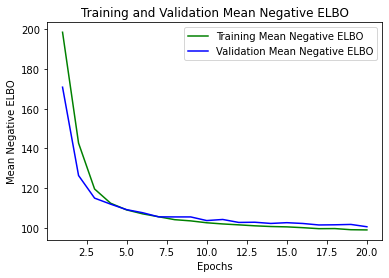

In [9]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def train_vae(num_epochs, patience=5):
    train_elbos = []
    val_elbos = []
    best_val_elbo = np.inf
    tolerance = 0
    epochs = num_epochs
    for epoch in tqdm(range(num_epochs)):
        overall_train_elbo = 0.0
        overall_val_elbo = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            x, _ = batch
            x = x.to(DEVICE)
            mu_z, log_var_z, probs_x = vae(x)
            x = torch.flatten(x, start_dim=1)
            log_p = -F.binary_cross_entropy(probs_x, x, reduction='sum')
            kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
            negative_elbo = -log_p + kl
            negative_elbo.backward()
            optimizer.step()
            overall_train_elbo += negative_elbo.item()

        for batch in val_dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            with torch.no_grad():
                mu_z, log_var_z, probs_x = vae(x)
                x = torch.flatten(x, start_dim=1)
                log_p = -F.binary_cross_entropy(probs_x, x, reduction='sum')
                kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
                negative_elbo = -log_p + kl
                overall_val_elbo += negative_elbo.item()
        mean_train_elbo = overall_train_elbo / NUM_TRAIN
        mean_val_elbo = overall_val_elbo / NUM_VAL
        print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, mean_train_elbo, mean_val_elbo))
        train_elbos.append(mean_train_elbo)
        val_elbos.append(mean_val_elbo)
        if mean_val_elbo < best_val_elbo:
            best_val_elbo = mean_val_elbo
            tolerance = 0
        else:
            tolerance += 1
            if tolerance == patience:
                print('Early Stopped!')
                epochs = epoch + 1
                break
    plt.plot(range(1, epochs + 1), train_elbos, 'g', label='Training Mean Negative ELBO')
    plt.plot(range(1, epochs + 1), val_elbos, 'b', label='Validation Mean Negative ELBO')
    plt.title('Training and Validation Mean Negative ELBO')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Negative ELBO')
    plt.legend()
    plt.show()
train_vae(num_epochs=20)

In [10]:
def test_vae():
    x, _ = next(iter(test_dataloader))
    x = x.to(DEVICE)
    with torch.no_grad():
        _, _, probs_x = vae(x)
        # x_recon = vae.reconstruct(probs_x)
        x_recon = probs_x
        return x, x_recon
test_batch, test_batch_recon = test_vae()

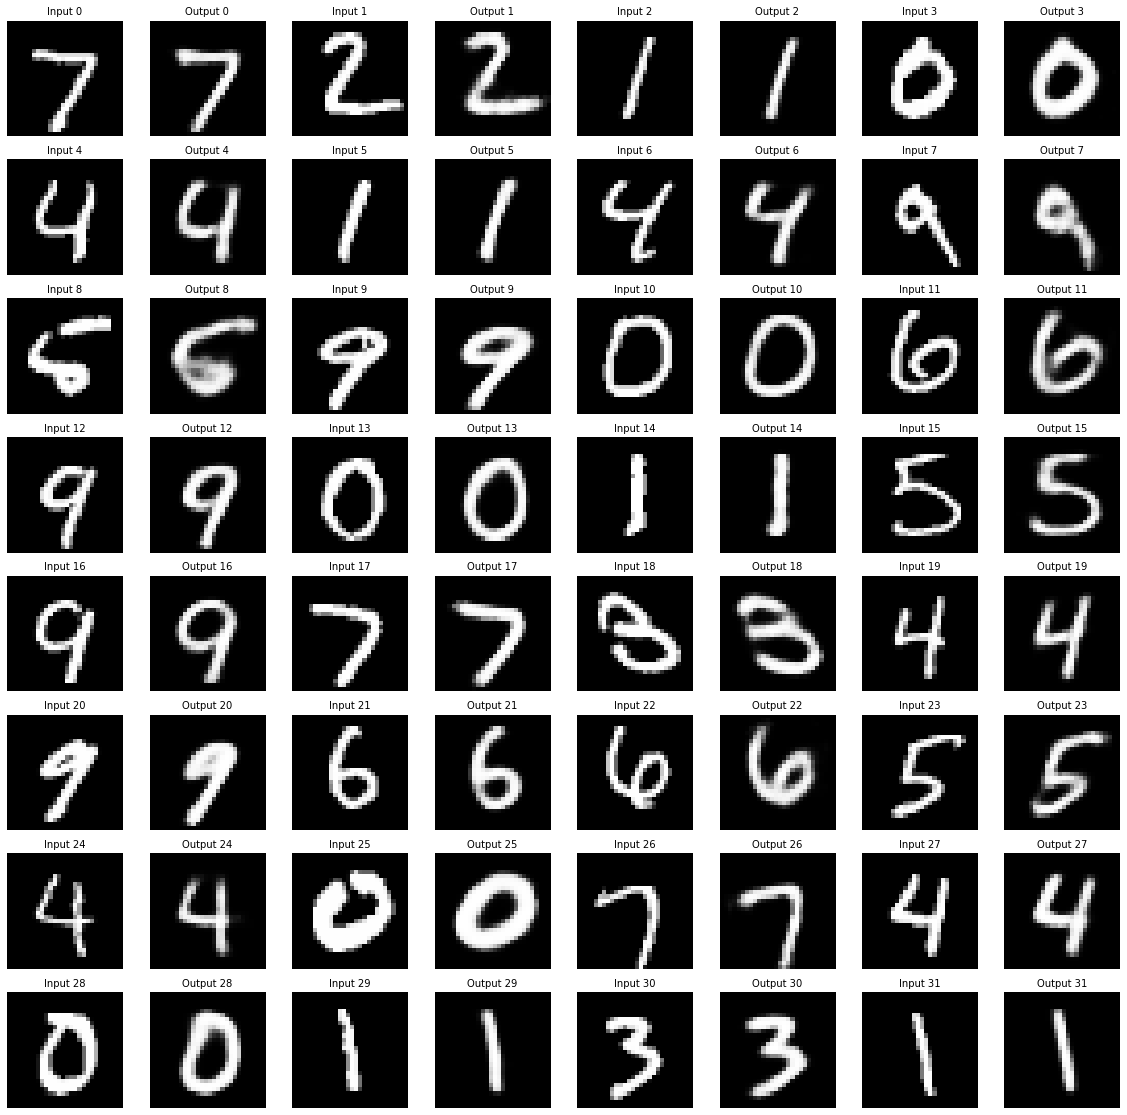

In [11]:
def show_images(x, x_recon):
    """ plots first 32 images and reconstructions"""
    x = x.view(x.shape[0], 28, 28)
    x_recon = x_recon.view(x_recon.shape[0], 28, 28)
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    for i in range(8):
        for j in range(4):
            ax[i][2*j].imshow(x[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j+1].imshow(x_recon[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j].set_title(f"Input {i*4+j}", fontsize=10)
            ax[i][2*j+1].set_title(f"Output {i*4+j}", fontsize=10)
            ax[i][2*j].axis('off')
            ax[i][2*j+1].axis('off')
show_images(test_batch, test_batch_recon)

In [33]:
test_img_idx = torch.randint(test_x.shape[0], size=(1,))
test_img = test_x[test_img_idx]
test_img_label = test_y[test_img_idx]

cand_img_idxes = (test_y != test_img_label).nonzero()[:10].squeeze(1)
cand_imgs = test_x[cand_img_idxes]
cand_img_labels = test_y[cand_img_idxes]

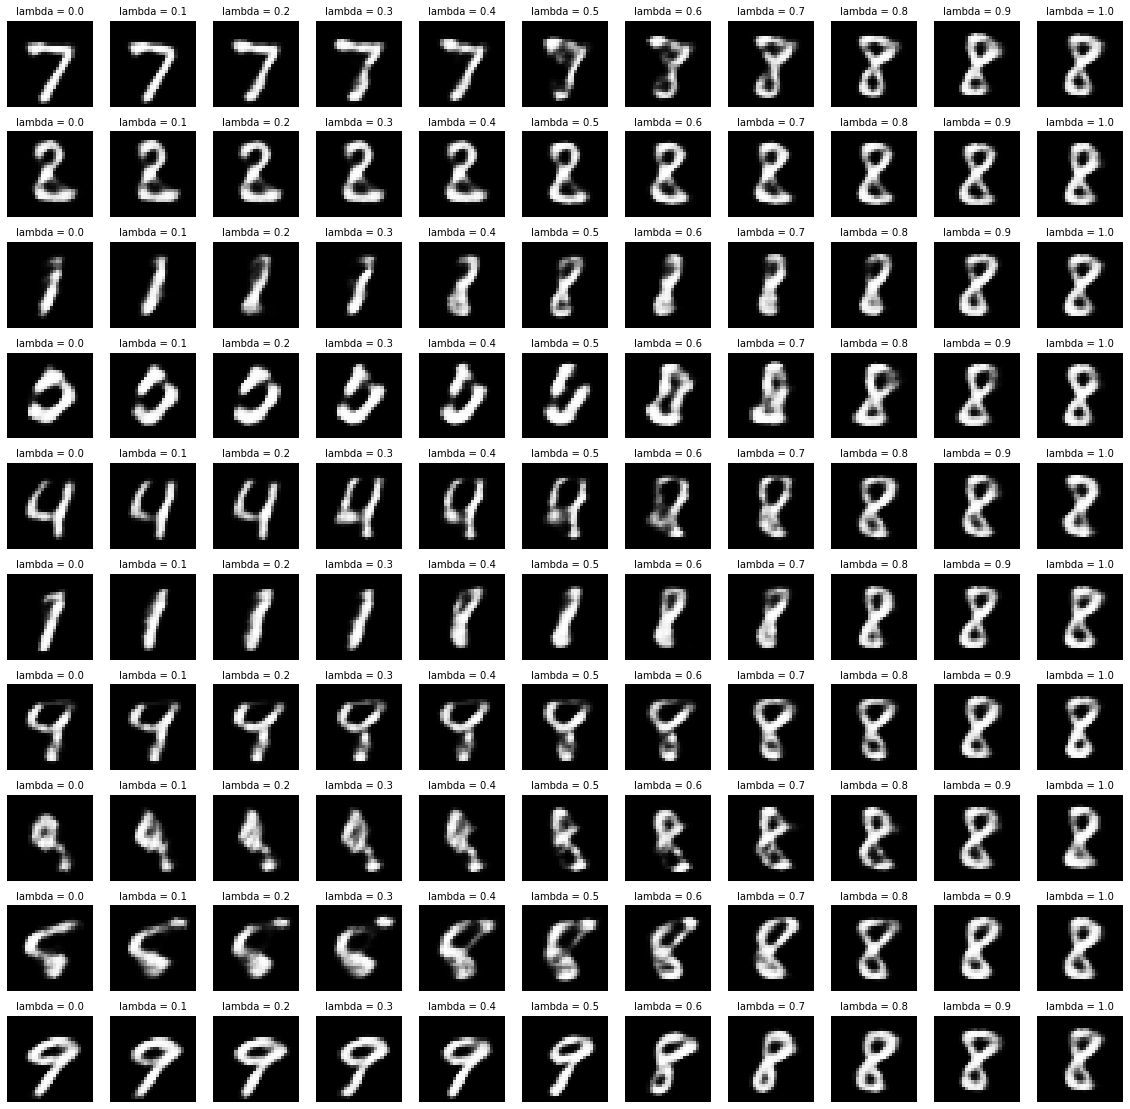

In [35]:
def interpolate(lamb, img1, img2):
    x1 = img1.to(DEVICE)
    x2 = img2.to(DEVICE)
    with torch.no_grad():
        z1, _, _ = encoder(x1)
        z2, _, _ = encoder(x2)
        z = lamb * z1 + (1 - lamb) * z2
        x_recon = decoder(z)
        return x_recon

def plot_interpolate():
    lambs = [i / 10 for i in range(11)]
    fig, ax = plt.subplots(cand_imgs.shape[0], len(lambs), figsize=(20, 20))
    for i in range(cand_imgs.shape[0]):
        for j in range(len(lambs)):
            x_recon = interpolate(lambs[j], test_img, cand_imgs[i].unsqueeze(0))
            x_recon = x_recon.view(IMG_H, IMG_W)
            ax[i][j].imshow(x_recon.cpu().numpy(), cmap="Greys_r")
            ax[i][j].set_title(f"lambda = {lambs[j]}", fontsize=10)
            ax[i][j].axis('off')
plot_interpolate()